# Kaggle API


In [ ]:
#!rm -r /root/.kaggle

In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d jangedoo/utkface-new

 99% 329M/331M [00:16<00:00, 24.1MB/s]
100% 331M/331M [00:16<00:00, 21.4MB/s]


In [5]:
! unzip utkface-new.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_201701

In [ ]:
#! kaggle datasets list

# GPU

In [6]:
import tensorflow as tf

In [7]:
device_list = tf.test.gpu_device_name()

device_list

'/device:GPU:0'

In [8]:
!nvidia-smi

Sat May  6 20:44:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    51W / 400W |    691MiB / 40960MiB |      6%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PACKAGES

In [9]:
import numpy as np
import pandas as pd 
import os
import cv2
from sklearn.svm import SVC
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.color import rgb2gray
#import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from skimage.feature import hog
from skimage import data, exposure
import random
from keras import layers, losses
from keras.models import Model
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import math
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
def display(img):
    plt.imshow(img)
    plt.show()

def prediction_metrics_age(model, X_test, y_test, classes):
    preds = []
    truth = []
    y_hat = model.predict(X_test)

    for i in range(X_test.shape[0]):
        
        predict_index = np.argmax(y_hat[i])
        preds.append(predict_index) 
        
        true_index = np.argmax(y_test[i])
        truth.append(true_index)
        
    mcc = matthews_corrcoef(truth, preds)
    print("MCC: ", mcc)
    label = list(set(classes))
    cm = confusion_matrix(truth, preds)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label, yticklabels=label)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(truth, preds))

def prediction_metrics_gender(model, X_test, y_test, classes):

  y_hat = model.predict(X_test)
  y_hat = np.round(y_hat)   

  mcc = matthews_corrcoef(y_test, y_hat)
  print("MCC: ", mcc)
  label = list(set(classes))
  cm = confusion_matrix(y_test, y_hat)
  sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label, yticklabels=label)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()
  print(classification_report(y_test, y_hat))

In [11]:
#path server
#path = "/UTKFace/"
#path colab
path = "/content/utkface_aligned_cropped/UTKFace"
#path martim
#path = "../../../../DadosProj/UTKFace/"
#path alex
#path = "../../../data_project/UTKFace/"

files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
1_0_0_20170110213012671.jpg.chip.jpg


# DATA NORM

In [12]:
images = []
ages = []
genders = []
counter = 0

for file in files:
    if counter == 12500:
        break

    image = cv2.imread(os.path.join(path, file))
    if image is not None and image.any():
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(200, 200))
        image = image.reshape((image.shape[0], image.shape[1], 3)) 
        image = image / 255.0

        images.append(image)
        delimit = file.split('_')
        ages.append(int(delimit[0]))
        genders.append(int(delimit[1]))

        counter += 1
        
X = np.squeeze(images)

### Age classes
age_classes = []
for i in ages:
    i = int(i)
    if i <= 1:
        age_classes.append(0)
    if (i>1) and (i<=13):
        age_classes.append(1)
    if (i>13) and (i<17):
        age_classes.append(2)
    if (i>=17) and (i<30):
        age_classes.append(3)
    if (i>=30) and (i<60):
        age_classes.append(4)
    if i>=60:
        age_classes.append(5)

age_labels = ["Baby",   # index 0
        "Infant",       # index 1
        "Adolescent",   # index 2 
        "Young Adult",  # index 3 
        "Adult"         # index 4
        "Old Adult",    # index 5
        ]

age_categories = to_categorical(age_classes, num_classes=6)
age_categories[:20]
print("Age Classes finished")

Age Classes finished


# DISTRIBUTIONS

In [13]:
img_all = pd.DataFrame()
img_all["age"] = age_classes
img_all["gender"] = genders

img_gender = pd.DataFrame()
img_gender["gender"] = genders

img_age = pd.DataFrame()
img_age["age"] = age_classes

print("age\n", img_age.age.value_counts())
print("gender\n", img_gender.gender.value_counts())

age
 4    4810
3    4199
5    1404
1    1187
0     584
2     316
Name: age, dtype: int64
gender
 0    6561
1    5939
Name: gender, dtype: int64


## Ages

<ipython-input-14-6047e2ead716>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ages)


<Axes: ylabel='Density'>

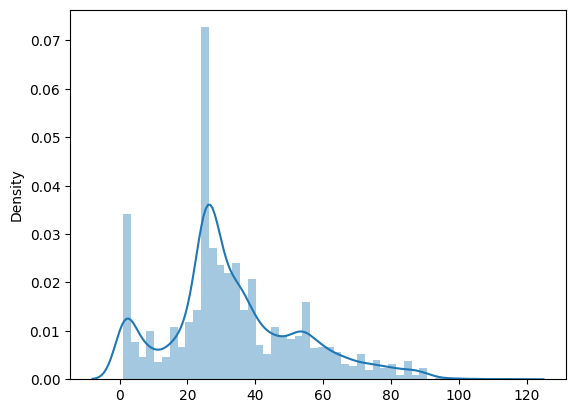

In [14]:
sns.distplot(ages)

## Age Classes

In [15]:
print(len(age_classes))
print(type(age_classes))
unique_values = list(set(age_classes))
print(unique_values)

12500
<class 'list'>
[0, 1, 2, 3, 4, 5]


<ipython-input-16-083d45ced2fd>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(age_classes)


<Axes: ylabel='Density'>

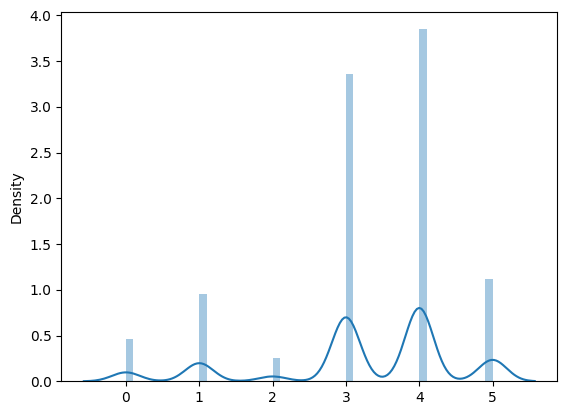

In [16]:
sns.distplot(age_classes)

## Gender

<ipython-input-17-3cfed0c9c84f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(genders)


<Axes: ylabel='Density'>

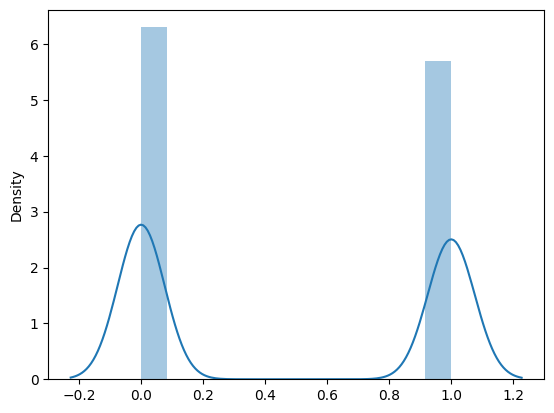

In [17]:
sns.distplot(genders)

# MODELS

In [18]:
def CNN (input_shape, output, activation):
    
    model = tf.keras.Sequential()

    
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = input_shape)) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
 

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))


    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(output, activation=activation))
    
    model.summary()
    
    return model

#otimizar 2k
#adicionar mais conv?
#Dropout antes do flaten apenas
#Mexer otimizador (lr)
#implementar early stoping (). Early Stoping tem patience: e.g., 10 epcohs, ele espera 10 epochs antes de parar.
#ir gravando cnn no servidor

## BASE

### Gender

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, genders, test_size=0.2, random_state=42)

In [20]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [21]:
model = CNN((200,200,3), 1, 'sigmoid')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0

In [22]:
#for age use categorical_crossentropy instead
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

history_base_gender = model.fit(X_train, y_train,
                    epochs=25,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/25
313/313 [==============================] - 17s 18ms/step - loss: 0.4847 - accuracy: 0.7711 - val_loss: 0.3743 - val_accuracy: 0.8352
Epoch 2/25
313/313 [==============================] - 3s 10ms/step - loss: 0.3428 - accuracy: 0.8475 - val_loss: 0.2997 - val_accuracy: 0.8676
Epoch 3/25
313/313 [==============================] - 3s 11ms/step - loss: 0.2961 - accuracy: 0.8708 - val_loss: 0.2978 - val_accuracy: 0.8684
Epoch 4/25
313/313 [==============================] - 3s 10ms/step - loss: 0.2688 - accuracy: 0.8804 - val_loss: 0.2749 - val_accuracy: 0.8820
Epoch 5/25
313/313 [==============================] - 3s 11ms/step - loss: 0.2492 - accuracy: 0.8941 - val_loss: 0.2748 - val_accuracy: 0.8796
Epoch 6/25
313/313 [==============================] - 3s 11ms/step - loss: 0.2209 - accuracy: 0.9047 - val_loss: 0.2699 - val_accuracy: 0.8908
Epoch 7/25
313/313 [==============================] - 3s 11ms/step - loss: 0.1948 - accuracy: 0.9196 - val_loss: 0.2785 - val_accuracy: 0.879

79/79 [==============================] - 1s 6ms/step
MCC:  0.7825761968532144


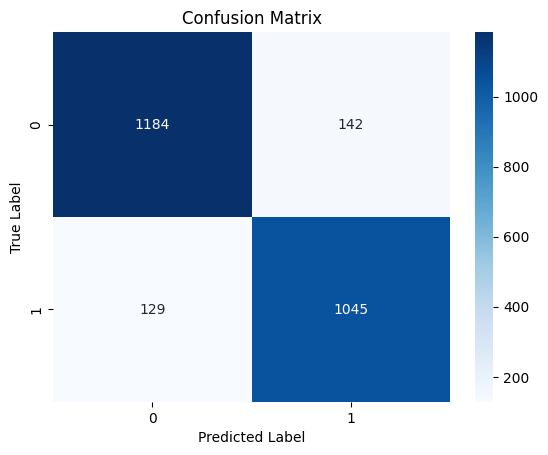

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1326
           1       0.88      0.89      0.89      1174

    accuracy                           0.89      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.89      0.89      0.89      2500



In [23]:
prediction_metrics_gender(model, X_test, y_test, genders)

### Age

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, age_categories, test_size = 0.2, shuffle = True)

In [25]:
model = CNN((200,200,3), 6, 'softmax')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 25, 25, 64)      

In [26]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_base_age = model.fit(X_train, y_train,
        batch_size=32,
        epochs=25,
        validation_data=(X_test, y_test),)

Epoch 1/25
313/313 [==============================] - 7s 17ms/step - loss: 1.3766 - accuracy: 0.4217 - val_loss: 1.1780 - val_accuracy: 0.5004
Epoch 2/25
313/313 [==============================] - 3s 11ms/step - loss: 1.1620 - accuracy: 0.5084 - val_loss: 1.0201 - val_accuracy: 0.5828
Epoch 3/25
313/313 [==============================] - 3s 11ms/step - loss: 1.0482 - accuracy: 0.5542 - val_loss: 0.9183 - val_accuracy: 0.6196
Epoch 4/25
313/313 [==============================] - 3s 11ms/step - loss: 0.9780 - accuracy: 0.5796 - val_loss: 0.9009 - val_accuracy: 0.6324
Epoch 5/25
313/313 [==============================] - 3s 11ms/step - loss: 0.9237 - accuracy: 0.6040 - val_loss: 0.8603 - val_accuracy: 0.6456
Epoch 6/25
313/313 [==============================] - 3s 11ms/step - loss: 0.8843 - accuracy: 0.6156 - val_loss: 0.8198 - val_accuracy: 0.6412
Epoch 7/25
313/313 [==============================] - 3s 11ms/step - loss: 0.8477 - accuracy: 0.6239 - val_loss: 0.8392 - val_accuracy: 0.6412

79/79 [==============================] - 1s 6ms/step
MCC:  0.507577593192628


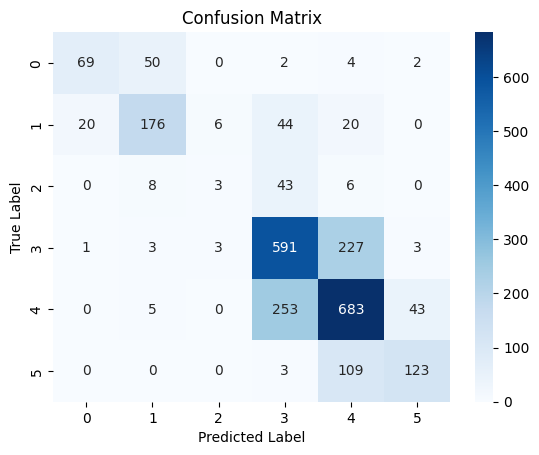

              precision    recall  f1-score   support

           0       0.77      0.54      0.64       127
           1       0.73      0.66      0.69       266
           2       0.25      0.05      0.08        60
           3       0.63      0.71      0.67       828
           4       0.65      0.69      0.67       984
           5       0.72      0.52      0.61       235

    accuracy                           0.66      2500
   macro avg       0.62      0.53      0.56      2500
weighted avg       0.66      0.66      0.65      2500



In [27]:
prediction_metrics_age(model, X_test, y_test, age_classes)

# DATA NOT NORM

In [28]:
images = []
ages = []
genders = []
counter = 0

for file in files:
    if counter == 12500:
        break

    image = cv2.imread(os.path.join(path, file))
    if image is not None and image.any():
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(200, 200))
        image = image.reshape((image.shape[0], image.shape[1], 3)) 
        #image = image / 255.0

        images.append(image)
        delimit = file.split('_')
        ages.append(int(delimit[0]))
        genders.append(int(delimit[1]))

        counter += 1
        
X = np.squeeze(images)

In [29]:
### Age classes
age_classes = []
for i in ages:
    i = int(i)
    if i <= 1:
        age_classes.append(0)
    if (i>1) and (i<=13):
        age_classes.append(1)
    if (i>13) and (i<17):
        age_classes.append(2)
    if (i>=17) and (i<30):
        age_classes.append(3)
    if (i>=30) and (i<60):
        age_classes.append(4)
    if i>=60:
        age_classes.append(5)

age_labels = ["Baby",   # index 0
        "Infant",       # index 1
        "Adolescent",   # index 2 
        "Young Adult",  # index 3 
        "Adult"         # index 4
        "Old Adult",    # index 5
        ]

age_categories = to_categorical(age_classes, num_classes=6)
age_categories[:20]
print("Age Classes finished")

Age Classes finished


In [30]:
img_all = pd.DataFrame()
img_all["age"] = age_classes
img_all["gender"] = genders

img_gender = pd.DataFrame()
img_gender["gender"] = genders

img_age = pd.DataFrame()
img_age["age"] = age_classes

print("age\n", img_age.age.value_counts())
print("gender\n", img_gender.gender.value_counts())

age
 4    4810
3    4199
5    1404
1    1187
0     584
2     316
Name: age, dtype: int64
gender
 0    6561
1    5939
Name: gender, dtype: int64


## HOG

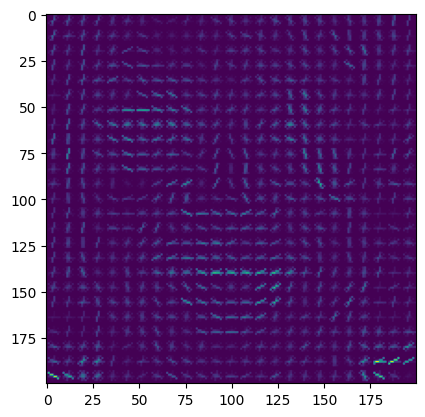

In [31]:
image_check = images[25]

# define HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# compute HOG features and visualize them
hog_features, hog_image = hog(image_check, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, visualize=True,channel_axis=2)



# rescale image intensity for better visualization
#hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# display HOG features
plt.imshow(hog_image)
plt.show()

In [32]:
# Extract HOG features from the images
hog_features = []
for img in images:
    #hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
    #                cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, multichannel=True, channel_axis=2)
    hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, channel_axis=2)
    
    hog_features.append(hog_feature)
hog_features = np.array(hog_features)

# Normalize the features to have zero mean and unit variance
mean = np.mean(hog_features, axis=0)
std = np.std(hog_features, axis=0)
hog_features_norm = (hog_features - mean) / std

### Gender

In [33]:
cnn = Sequential()

#tratado
cnn.add(layers.Reshape((144, 144, 1), input_shape=(20736,)))
#cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train[1].shape))


cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(Flatten())

cnn.add(Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 144, 144, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 144, 144, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 72, 72, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 36, 36, 64)       

In [34]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, genders, test_size=0.2, random_state=42)

In [35]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [36]:
cnn.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

history_hog_gender = cnn.fit(X_train, y_train,
                    epochs=25,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/25
313/313 [==============================] - 5s 8ms/step - loss: 0.7080 - accuracy: 0.5434 - val_loss: 0.6101 - val_accuracy: 0.7240
Epoch 2/25
313/313 [==============================] - 2s 6ms/step - loss: 0.5480 - accuracy: 0.7291 - val_loss: 0.5008 - val_accuracy: 0.7556
Epoch 3/25
313/313 [==============================] - 2s 6ms/step - loss: 0.4587 - accuracy: 0.7885 - val_loss: 0.4256 - val_accuracy: 0.8056
Epoch 4/25
313/313 [==============================] - 2s 6ms/step - loss: 0.4054 - accuracy: 0.8186 - val_loss: 0.4564 - val_accuracy: 0.7876
Epoch 5/25
313/313 [==============================] - 2s 6ms/step - loss: 0.3670 - accuracy: 0.8350 - val_loss: 0.3921 - val_accuracy: 0.8212
Epoch 6/25
313/313 [==============================] - 2s 6ms/step - loss: 0.3176 - accuracy: 0.8580 - val_loss: 0.4129 - val_accuracy: 0.8112
Epoch 7/25
313/313 [==============================] - 2s 6ms/step - loss: 0.2778 - accuracy: 0.8750 - val_loss: 0.4085 - val_accuracy: 0.8204
Epoch 

79/79 [==============================] - 0s 2ms/step
MCC:  0.6334937709592049


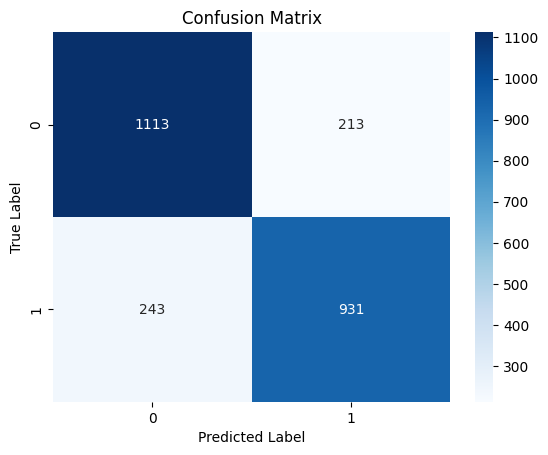

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1326
           1       0.81      0.79      0.80      1174

    accuracy                           0.82      2500
   macro avg       0.82      0.82      0.82      2500
weighted avg       0.82      0.82      0.82      2500



In [37]:
prediction_metrics_gender(cnn, X_test, y_test, genders)

### Age

In [38]:
cnn = Sequential()

cnn.add(layers.Reshape((144, 144, 1), input_shape=(20736,)))
#cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train[1].shape))

cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))

cnn.add(layers.MaxPooling2D(2,2))
cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(Flatten())

cnn.add(Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.2))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(6, activation='softmax'))

cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 144, 144, 1)       0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 72, 72, 1)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 18, 18, 64)      

In [39]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, age_categories, test_size = 0.2,shuffle = True)

In [40]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [41]:
cnn.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_hog_age = cnn.fit(X_train, y_train,
        batch_size=32,
        epochs=25,
        validation_data=(X_test, y_test),)

Epoch 1/25
313/313 [==============================] - 4s 6ms/step - loss: 1.4685 - accuracy: 0.3895 - val_loss: 1.2690 - val_accuracy: 0.4344
Epoch 2/25
313/313 [==============================] - 1s 5ms/step - loss: 1.2191 - accuracy: 0.4699 - val_loss: 1.1118 - val_accuracy: 0.5292
Epoch 3/25
313/313 [==============================] - 2s 5ms/step - loss: 1.0862 - accuracy: 0.5430 - val_loss: 1.0404 - val_accuracy: 0.5704
Epoch 4/25
313/313 [==============================] - 1s 5ms/step - loss: 1.0179 - accuracy: 0.5681 - val_loss: 1.0129 - val_accuracy: 0.5844
Epoch 5/25
313/313 [==============================] - 2s 5ms/step - loss: 0.9302 - accuracy: 0.6034 - val_loss: 1.0277 - val_accuracy: 0.5632
Epoch 6/25
313/313 [==============================] - 2s 5ms/step - loss: 0.8602 - accuracy: 0.6279 - val_loss: 1.0781 - val_accuracy: 0.5660
Epoch 7/25
313/313 [==============================] - 1s 5ms/step - loss: 0.7731 - accuracy: 0.6699 - val_loss: 1.0087 - val_accuracy: 0.5712
Epoch 

79/79 [==============================] - 0s 2ms/step
MCC:  0.38036112413353196


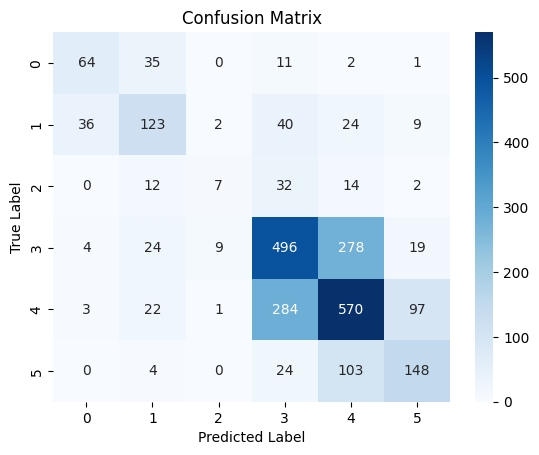

              precision    recall  f1-score   support

           0       0.60      0.57      0.58       113
           1       0.56      0.53      0.54       234
           2       0.37      0.10      0.16        67
           3       0.56      0.60      0.58       830
           4       0.58      0.58      0.58       977
           5       0.54      0.53      0.53       279

    accuracy                           0.56      2500
   macro avg       0.53      0.48      0.50      2500
weighted avg       0.56      0.56      0.56      2500



In [42]:
prediction_metrics_age(cnn, X_test, y_test, age_classes)

## ORB

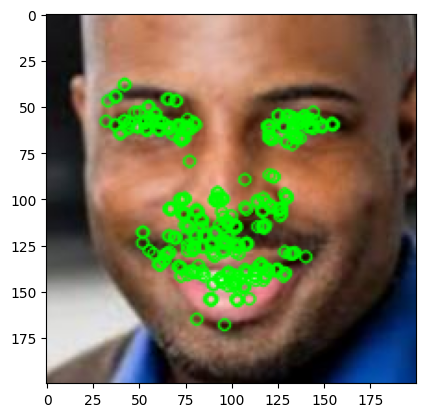

In [43]:
image_check = images[1]

orb = cv2.ORB_create()

kp = orb.detect(image_check, None)

kp, des = orb.compute(image_check, kp)

img2 = cv2.drawKeypoints(image_check, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2)
plt.show()

In [44]:
image_check = images[1]

orb = cv2.ORB_create()
# define minimum and maximum keypoints
MIN_KEYPOINTS = 100
orb_features = []
orb_genders = []
orb_ages = []

# loop over images and keypoints
for i, img in enumerate(images):
    keypoints, descriptors = orb.detectAndCompute(img, None)
    keypoints, descriptors = orb.compute(image_check, keypoints)
    keypoints = list(keypoints)    
    # check if number of keypoints is between min and max
    if len(keypoints) < MIN_KEYPOINTS:
        continue
        
    # remove extra keypoints randomly
    while len(keypoints) > MIN_KEYPOINTS:
        idx = random.randint(0, len(keypoints)-1)
        keypoints.pop(idx)
        descriptors = np.delete(descriptors, idx, axis=0)
        
    # add descriptors to feature list
    orb_features.append(np.ndarray.flatten(descriptors))
    orb_genders.append(genders[i])
    orb_ages.append(age_categories[i])

In [45]:
mean = np.mean(orb_features, axis=0)
std = np.std(orb_features, axis=0)
orb_features_norm = (orb_features - mean) / std

### Gender 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, orb_genders, test_size=0.20, random_state=42)

In [47]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [48]:
cnn = Sequential()

# Input shape is (3200,)
cnn.add(layers.Reshape((50, 64, 1), input_shape=X_train[0].shape))

cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(Flatten())
cnn.add(layers.Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 50, 64, 1)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 50, 64, 16)        160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 25, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 25, 32, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 16, 64)       

In [49]:
cnn.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

history_orb_gender = cnn.fit(X_train, y_train,
                        epochs=25,
                        batch_size=32,
                        validation_data=(X_test, y_test))

Epoch 1/25
186/186 [==============================] - 3s 7ms/step - loss: 0.6948 - accuracy: 0.5228 - val_loss: 0.6921 - val_accuracy: 0.5202
Epoch 2/25
186/186 [==============================] - 1s 5ms/step - loss: 0.6912 - accuracy: 0.5302 - val_loss: 0.6924 - val_accuracy: 0.5202
Epoch 3/25
186/186 [==============================] - 1s 5ms/step - loss: 0.6913 - accuracy: 0.5319 - val_loss: 0.6920 - val_accuracy: 0.5202
Epoch 4/25
186/186 [==============================] - 1s 5ms/step - loss: 0.6898 - accuracy: 0.5346 - val_loss: 0.6874 - val_accuracy: 0.5202
Epoch 5/25
186/186 [==============================] - 1s 5ms/step - loss: 0.6884 - accuracy: 0.5353 - val_loss: 0.6758 - val_accuracy: 0.5803
Epoch 6/25
186/186 [==============================] - 1s 5ms/step - loss: 0.6802 - accuracy: 0.5700 - val_loss: 0.6744 - val_accuracy: 0.6147
Epoch 7/25
186/186 [==============================] - 1s 5ms/step - loss: 0.6715 - accuracy: 0.5835 - val_loss: 0.6549 - val_accuracy: 0.6134
Epoch 

47/47 [==============================] - 0s 2ms/step
MCC:  0.21921445745557241


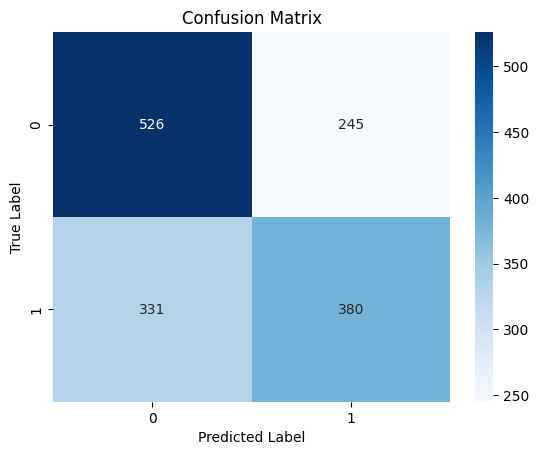

              precision    recall  f1-score   support

           0       0.61      0.68      0.65       771
           1       0.61      0.53      0.57       711

    accuracy                           0.61      1482
   macro avg       0.61      0.61      0.61      1482
weighted avg       0.61      0.61      0.61      1482



In [50]:
prediction_metrics_gender(cnn, X_test, y_test, orb_genders)

### Age

In [51]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, orb_ages, test_size=0.20, random_state=42)

In [52]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [53]:
cnn = Sequential()

# Input shape is (3200,)
cnn.add(layers.Reshape((50, 64, 1), input_shape=X_train[0].shape))


cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(Flatten())

cnn.add(layers.Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

cnn.add(layers.Dense(6, activation='softmax'))

#cnn.summary()

In [54]:
cnn.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

history_orb_gender = cnn.fit(X_train, y_train,
                        epochs=25,
                        batch_size=32,
                        validation_data=(X_test, y_test))

Epoch 1/25
186/186 [==============================] - 3s 6ms/step - loss: 0.4293 - accuracy: 0.3334 - val_loss: 0.3876 - val_accuracy: 0.3704
Epoch 2/25
186/186 [==============================] - 1s 5ms/step - loss: 0.4083 - accuracy: 0.3593 - val_loss: 0.3833 - val_accuracy: 0.3711
Epoch 3/25
186/186 [==============================] - 1s 5ms/step - loss: 0.3953 - accuracy: 0.3712 - val_loss: 0.3747 - val_accuracy: 0.3745
Epoch 4/25
186/186 [==============================] - 1s 5ms/step - loss: 0.3887 - accuracy: 0.3814 - val_loss: 0.3695 - val_accuracy: 0.4069
Epoch 5/25
186/186 [==============================] - 1s 5ms/step - loss: 0.3822 - accuracy: 0.3977 - val_loss: 0.3651 - val_accuracy: 0.4082
Epoch 6/25
186/186 [==============================] - 1s 5ms/step - loss: 0.3753 - accuracy: 0.3979 - val_loss: 0.3631 - val_accuracy: 0.4170
Epoch 7/25
186/186 [==============================] - 1s 5ms/step - loss: 0.3711 - accuracy: 0.4114 - val_loss: 0.3622 - val_accuracy: 0.4170
Epoch 

47/47 [==============================] - 0s 2ms/step
MCC:  0.09737118742804517


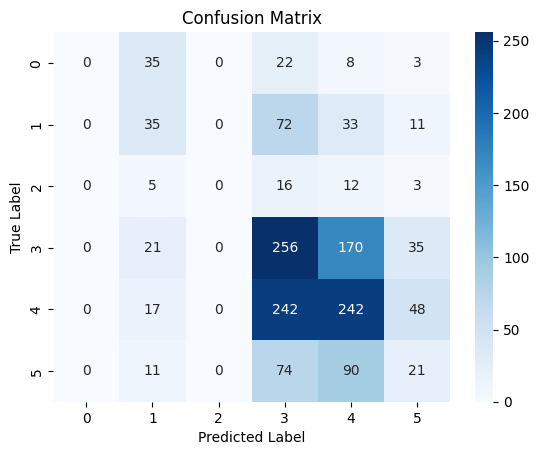

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        68
           1       0.28      0.23      0.25       151
           2       0.00      0.00      0.00        36
           3       0.38      0.53      0.44       482
           4       0.44      0.44      0.44       549
           5       0.17      0.11      0.13       196

    accuracy                           0.37      1482
   macro avg       0.21      0.22      0.21      1482
weighted avg       0.34      0.37      0.35      1482



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
prediction_metrics_age(cnn, X_test, y_test, age_classes)

# DATA NORM

In [56]:
images = []
ages = []
genders = []
counter = 0

for file in files:
    if counter == 12500:
        break

    image = cv2.imread(os.path.join(path, file))
    if image is not None and image.any():
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(200, 200))
        image = image.reshape((image.shape[0], image.shape[1], 3)) 
        image = image / 255.0

        images.append(image)
        delimit = file.split('_')
        ages.append(int(delimit[0]))
        genders.append(int(delimit[1]))

        counter += 1
        
X = np.squeeze(images)

### Age classes
age_classes = []
for i in ages:
    i = int(i)
    if i <= 1:
        age_classes.append(0)
    if (i>1) and (i<=13):
        age_classes.append(1)
    if (i>13) and (i<17):
        age_classes.append(2)
    if (i>=17) and (i<30):
        age_classes.append(3)
    if (i>=30) and (i<60):
        age_classes.append(4)
    if i>=60:
        age_classes.append(5)

age_labels = ["Baby",   # index 0
        "Infant",       # index 1
        "Adolescent",   # index 2 
        "Young Adult",  # index 3 
        "Adult"         # index 4
        "Old Adult",    # index 5
        ]

age_categories = to_categorical(age_classes, num_classes=6)
age_categories[:20]
print("Age Classes finished")

Age Classes finished


## VGG 16

In [57]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in VGG_model.layers:
	layer.trainable = False
	
VGG_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [58]:
X = np.stack(images)
X = VGG_model.predict(X)

391/391 [==============================] - 8s 17ms/step


### Gender

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, genders, test_size=0.2, random_state=42)

In [60]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [61]:
    model = tf.keras.Sequential()

    # Must define the input shape in the first layer of the neural network
    
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = (6, 6, 512))) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    


    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))

    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 6, 6, 16)          73744     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 3, 3, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 1, 1, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 1, 64)          18496     
                                                                 
 flatten_6 (Flatten)         (None, 64)               

In [62]:
#for age use categorical_crossentropy instead
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

history_VGG16_gender = model.fit(X_train, y_train,
                    epochs=25,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/25
313/313 [==============================] - 4s 7ms/step - loss: 0.4556 - accuracy: 0.7773 - val_loss: 0.4095 - val_accuracy: 0.8048
Epoch 2/25
313/313 [==============================] - 2s 5ms/step - loss: 0.3045 - accuracy: 0.8746 - val_loss: 0.2933 - val_accuracy: 0.8568
Epoch 3/25
313/313 [==============================] - 2s 5ms/step - loss: 0.2617 - accuracy: 0.8929 - val_loss: 0.2730 - val_accuracy: 0.8836
Epoch 4/25
313/313 [==============================] - 2s 5ms/step - loss: 0.2315 - accuracy: 0.9074 - val_loss: 0.2961 - val_accuracy: 0.8736
Epoch 5/25
313/313 [==============================] - 2s 5ms/step - loss: 0.2063 - accuracy: 0.9188 - val_loss: 0.3001 - val_accuracy: 0.8688
Epoch 6/25
313/313 [==============================] - 2s 5ms/step - loss: 0.1876 - accuracy: 0.9283 - val_loss: 0.3115 - val_accuracy: 0.8772
Epoch 7/25
313/313 [==============================] - 2s 5ms/step - loss: 0.1593 - accuracy: 0.9416 - val_loss: 0.3176 - val_accuracy: 0.8692
Epoch 

79/79 [==============================] - 0s 2ms/step
MCC:  0.7496360361538621


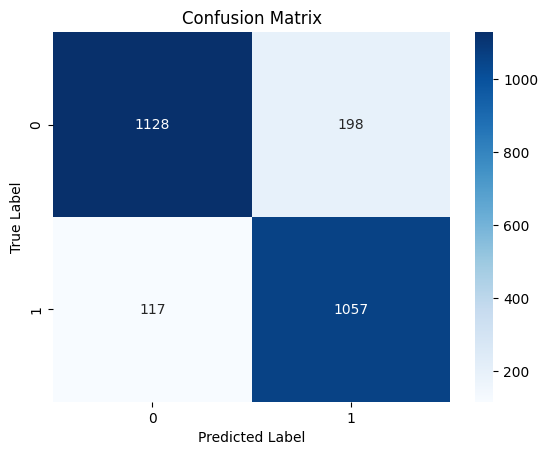

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1326
           1       0.84      0.90      0.87      1174

    accuracy                           0.87      2500
   macro avg       0.87      0.88      0.87      2500
weighted avg       0.88      0.87      0.87      2500



In [63]:
prediction_metrics_gender(model, X_test, y_test, genders)

### Age

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, age_categories, test_size=0.2, random_state=42)

In [65]:
    model = tf.keras.Sequential()

    # Must define the input shape in the first layer of the neural network
    
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = (6, 6, 512))) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    


    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))

    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(6, activation='softmax'))
    
    model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 6, 6, 16)          73744     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 3, 3, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 1, 1, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 1, 1, 64)          18496     
                                                                 
 flatten_7 (Flatten)         (None, 64)               

In [66]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_VGG16_age = model.fit(X_train, y_train,
        batch_size=32,
        epochs=25,
        validation_data=(X_test, y_test),)

Epoch 1/25
313/313 [==============================] - 4s 6ms/step - loss: 1.1293 - accuracy: 0.5106 - val_loss: 0.8933 - val_accuracy: 0.6068
Epoch 2/25
313/313 [==============================] - 2s 5ms/step - loss: 0.9161 - accuracy: 0.6031 - val_loss: 0.8603 - val_accuracy: 0.6228
Epoch 3/25
313/313 [==============================] - 2s 5ms/step - loss: 0.8288 - accuracy: 0.6525 - val_loss: 0.8389 - val_accuracy: 0.6444
Epoch 4/25
313/313 [==============================] - 2s 5ms/step - loss: 0.7677 - accuracy: 0.6748 - val_loss: 0.8038 - val_accuracy: 0.6504
Epoch 5/25
313/313 [==============================] - 2s 5ms/step - loss: 0.7061 - accuracy: 0.6967 - val_loss: 0.8080 - val_accuracy: 0.6488
Epoch 6/25
313/313 [==============================] - 2s 5ms/step - loss: 0.6658 - accuracy: 0.7234 - val_loss: 0.8127 - val_accuracy: 0.6588
Epoch 7/25
313/313 [==============================] - 2s 5ms/step - loss: 0.6242 - accuracy: 0.7445 - val_loss: 0.8956 - val_accuracy: 0.6380
Epoch 

79/79 [==============================] - 0s 2ms/step
MCC:  0.0073472109187139225


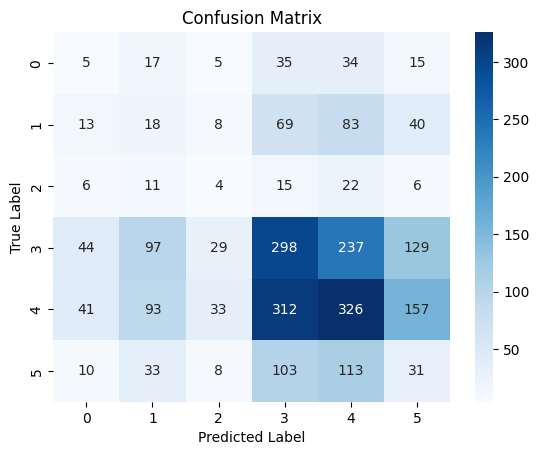

              precision    recall  f1-score   support

           0       0.04      0.05      0.04       111
           1       0.07      0.08      0.07       231
           2       0.05      0.06      0.05        64
           3       0.36      0.36      0.36       834
           4       0.40      0.34      0.37       962
           5       0.08      0.10      0.09       298

    accuracy                           0.27      2500
   macro avg       0.17      0.16      0.16      2500
weighted avg       0.29      0.27      0.28      2500



In [67]:
prediction_metrics_age(model, X_test, y_train, age_classes)

## Autoencoder

### Gender

In [68]:
X_train, X_test, y_train, y_test = train_test_split(images, genders, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))

In [69]:
# binary cross entropy is good for imagprint("Autoencoder Started")
#### AUtoencoder
input = layers.Input(shape=(200, 200, 3))

#valor alto apanha artefactos, e valor baixo nao captura bem as features da imagem
latent_dim = 2000

## Classe 

# Encoder

#didnt increase filter count in encoder and decrease equally in decoder because
#it can lead to overfitting

x = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides = 2)(input)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#dividir imagem por factor de 2
x = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides = 2)(x)#reduziu se nr de filtros para 32 porque foi decidido factor de 32 filtros
#x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#25*25*16=10000
x = layers.Flatten()(x)
enc = layers.Dense(latent_dim, activation='relu')(x)

# Decoder

#having conv2D here helps to avoid checkerboard artifacts
#which are alternating points of colors (like checkerboard)
#that are consequence of deconvolutioning an image and cause 
#loss of quality in final reconstruction
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)

#equivalente a fazer dense layer no fim do encoder e no inicio do decoder
#fazer a layer dense fica um vector
#fazer reshape depois do 2 dense para voltar a ter imagem do vetor criado

x = layers.Dense(25*25*16, activation='relu')(enc)
x = layers.Reshape((25,25,16))(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same", strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
output = layers.Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same', strides = 2)(x)

#maybe use strides in the layers too
#example:
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)

# Autoencoder
autoencoder = Model(input, output)

# binary cross entropy is good for image feature extraction especially when images are normalized
autoencoder.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

autoencoder.summary()#e feature extraction especially when images are normalized


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_23 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_24 (Conv2D)          (None, 50, 50, 32)        18464     
                                                                 
 conv2d_25 (Conv2D)          (None, 25, 25, 16)        4624      
                                                                 
 flatten_8 (Flatten)         (None, 10000)             0         
                                                                 
 dense_16 (Dense)            (None, 2000)              20002000  
                                                                 
 dense_17 (Dense)            (None, 10000)             200100

In [70]:
#using validation_data is good for detecting overfitting as 
#it does early stopping when the performance is no longer improving

autoencoder.fit(x = X_train, 
                y = X_train,
                epochs = 25,
                shuffle = True,
                batch_size = 32,
                validation_data = (X_test, X_test),)

Epoch 1/25
313/313 [==============================] - 13s 31ms/step - loss: 0.6072 - accuracy: 0.9227 - val_loss: 0.5740 - val_accuracy: 0.9220
Epoch 2/25
313/313 [==============================] - 6s 21ms/step - loss: 0.5683 - accuracy: 0.9230 - val_loss: 0.5653 - val_accuracy: 0.9167
Epoch 3/25
313/313 [==============================] - 7s 21ms/step - loss: 0.5622 - accuracy: 0.9204 - val_loss: 0.5616 - val_accuracy: 0.9192
Epoch 4/25
313/313 [==============================] - 7s 21ms/step - loss: 0.5593 - accuracy: 0.9203 - val_loss: 0.5594 - val_accuracy: 0.9208
Epoch 5/25
313/313 [==============================] - 7s 21ms/step - loss: 0.5572 - accuracy: 0.9225 - val_loss: 0.5579 - val_accuracy: 0.9237
Epoch 6/25
313/313 [==============================] - 7s 21ms/step - loss: 0.5558 - accuracy: 0.9243 - val_loss: 0.5569 - val_accuracy: 0.9242
Epoch 7/25
313/313 [==============================] - 6s 21ms/step - loss: 0.5548 - accuracy: 0.9255 - val_loss: 0.5558 - val_accuracy: 0.928

In [71]:
new_model = Model(input, enc)

encoded_train = new_model.predict(X_train)
encoded_test = new_model.predict(X_test)

encoded_train = np.asarray(encoded_train)
y_train = np.asarray(y_train)

encoded_test = np.asarray(encoded_test)
y_test = np.asarray(y_test)

79/79 [==============================] - 0s 5ms/step


In [72]:
cnn = Sequential()

# Input shape is (2000,)
cnn.add(layers.Reshape((40, 50, 1), input_shape=encoded_train[0].shape))

cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(Flatten())

cnn.add(Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 40, 50, 1)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 40, 50, 16)        160       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 20, 25, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 20, 25, 32)        4640      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 10, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 10, 12, 64)       

In [73]:
#for age use categorical_crossentropy instead
cnn.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

history_autoencoder_gender = cnn.fit(encoded_train, y_train,
                    epochs=25,
                    batch_size=32,
                    validation_data=(encoded_test, y_test))

Epoch 1/25
313/313 [==============================] - 4s 6ms/step - loss: 0.5746 - accuracy: 0.6999 - val_loss: 0.4576 - val_accuracy: 0.8016
Epoch 2/25
313/313 [==============================] - 1s 5ms/step - loss: 0.4158 - accuracy: 0.8170 - val_loss: 0.3979 - val_accuracy: 0.8200
Epoch 3/25
313/313 [==============================] - 1s 5ms/step - loss: 0.3698 - accuracy: 0.8414 - val_loss: 0.3611 - val_accuracy: 0.8412
Epoch 4/25
313/313 [==============================] - 1s 5ms/step - loss: 0.3268 - accuracy: 0.8620 - val_loss: 0.3522 - val_accuracy: 0.8400
Epoch 5/25
313/313 [==============================] - 1s 5ms/step - loss: 0.3091 - accuracy: 0.8723 - val_loss: 0.3547 - val_accuracy: 0.8464
Epoch 6/25
313/313 [==============================] - 1s 5ms/step - loss: 0.2829 - accuracy: 0.8819 - val_loss: 0.3522 - val_accuracy: 0.8420
Epoch 7/25
313/313 [==============================] - 1s 5ms/step - loss: 0.2664 - accuracy: 0.8895 - val_loss: 0.3477 - val_accuracy: 0.8480
Epoch 

79/79 [==============================] - 0s 2ms/step
MCC:  0.6755136056301952


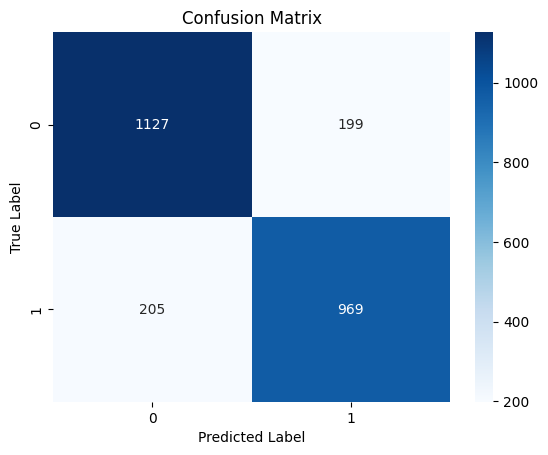

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1326
           1       0.83      0.83      0.83      1174

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500



In [74]:
prediction_metrics_gender(cnn, encoded_test, y_test, genders)

### Age

In [75]:
X_train, X_test, y_train, y_test = train_test_split(images, age_categories, test_size=0.2, random_state=42)

In [76]:
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))

In [77]:
# binary cross entropy is good for imagprint("Autoencoder Started")
#### AUtoencoder
input = layers.Input(shape=(200, 200, 3))

#valor alto apanha artefactos, e valor baixo nao captura bem as features da imagem
latent_dim = 2000

## Classe 

# Encoder

#didnt increase filter count in encoder and decrease equally in decoder because
#it can lead to overfitting

x = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides = 2)(input)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#dividir imagem por factor de 2
x = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides = 2)(x)#reduziu se nr de filtros para 32 porque foi decidido factor de 32 filtros
#x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#25*25*16=10000
x = layers.Flatten()(x)
enc = layers.Dense(latent_dim, activation='relu')(x)

# Decoder

#having conv2D here helps to avoid checkerboard artifacts
#which are alternating points of colors (like checkerboard)
#that are consequence of deconvolutioning an image and cause 
#loss of quality in final reconstruction
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)

#equivalente a fazer dense layer no fim do encoder e no inicio do decoder
#fazer a layer dense fica um vector
#fazer reshape depois do 2 dense para voltar a ter imagem do vetor criado

x = layers.Dense(25*25*16, activation='relu')(enc)
x = layers.Reshape((25,25,16))(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same", strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
output = layers.Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same', strides = 2)(x)

#maybe use strides in the layers too
#example:
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)

# Autoencoder
autoencoder = Model(input, output)

# binary cross entropy is good for image feature extraction especially when images are normalized
autoencoder.compile(optimizer="adam", loss="binary_crossentropy",
            metrics=['accuracy'])

autoencoder.summary()#e feature extraction especially when images are normalized

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_29 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_30 (Conv2D)          (None, 50, 50, 32)        18464     
                                                                 
 conv2d_31 (Conv2D)          (None, 25, 25, 16)        4624      
                                                                 
 flatten_10 (Flatten)        (None, 10000)             0         
                                                                 
 dense_20 (Dense)            (None, 2000)              20002000  
                                                                 
 dense_21 (Dense)            (None, 10000)             2001

In [78]:
autoencoder.fit(x = X_train, 
                y = X_train,
                epochs = 25,
                shuffle = True,
                batch_size = 32,
                validation_data = (X_test, X_test),)


Epoch 1/25
313/313 [==============================] - 12s 29ms/step - loss: 0.6038 - accuracy: 0.9214 - val_loss: 0.5733 - val_accuracy: 0.9189
Epoch 2/25
313/313 [==============================] - 7s 21ms/step - loss: 0.5673 - accuracy: 0.9207 - val_loss: 0.5664 - val_accuracy: 0.9146
Epoch 3/25
313/313 [==============================] - 6s 21ms/step - loss: 0.5619 - accuracy: 0.9186 - val_loss: 0.5611 - val_accuracy: 0.9192
Epoch 4/25
313/313 [==============================] - 7s 21ms/step - loss: 0.5588 - accuracy: 0.9194 - val_loss: 0.5588 - val_accuracy: 0.9242
Epoch 5/25
313/313 [==============================] - 6s 21ms/step - loss: 0.5570 - accuracy: 0.9220 - val_loss: 0.5573 - val_accuracy: 0.9212
Epoch 6/25
313/313 [==============================] - 6s 21ms/step - loss: 0.5556 - accuracy: 0.9242 - val_loss: 0.5570 - val_accuracy: 0.9283
Epoch 7/25
313/313 [==============================] - 7s 21ms/step - loss: 0.5548 - accuracy: 0.9260 - val_loss: 0.5559 - val_accuracy: 0.931

In [79]:
new_model = Model(input, enc)
encoded_train = new_model.predict(X_train)
encoded_test = new_model.predict(X_test)

79/79 [==============================] - 0s 5ms/step


In [80]:
encoded_train = np.asarray(encoded_train)
y_train = np.asarray(y_train)

encoded_test = np.asarray(encoded_test)
y_test = np.asarray(y_test)

In [81]:
cnn = Sequential()

# Input shape is (2000,)
cnn.add(layers.Reshape((40, 50, 1), input_shape=encoded_train[0].shape))

cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(Flatten())

cnn.add(Dense(64, activation='relu'))

cnn.add(layers.Dropout(0.5))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(layers.Dense(6, activation='softmax'))

cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 40, 50, 1)         0         
                                                                 
 conv2d_32 (Conv2D)          (None, 40, 50, 16)        160       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 20, 25, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 20, 25, 32)        4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 10, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 10, 12, 64)       

In [82]:
cnn.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_autoencoder_age = cnn.fit(encoded_train, y_train,
        batch_size=32,
        epochs=25,
        validation_data=(encoded_test, y_test),)

Epoch 1/25
313/313 [==============================] - 3s 5ms/step - loss: 1.4527 - accuracy: 0.3814 - val_loss: 1.3252 - val_accuracy: 0.4600
Epoch 2/25
313/313 [==============================] - 1s 4ms/step - loss: 1.2672 - accuracy: 0.4438 - val_loss: 1.1619 - val_accuracy: 0.4904
Epoch 3/25
313/313 [==============================] - 1s 4ms/step - loss: 1.1537 - accuracy: 0.4824 - val_loss: 1.0771 - val_accuracy: 0.5256
Epoch 4/25
313/313 [==============================] - 1s 4ms/step - loss: 1.0789 - accuracy: 0.5254 - val_loss: 1.0190 - val_accuracy: 0.5600
Epoch 5/25
313/313 [==============================] - 1s 4ms/step - loss: 1.0281 - accuracy: 0.5507 - val_loss: 0.9667 - val_accuracy: 0.5800
Epoch 6/25
313/313 [==============================] - 1s 4ms/step - loss: 0.9867 - accuracy: 0.5708 - val_loss: 0.9565 - val_accuracy: 0.5928
Epoch 7/25
313/313 [==============================] - 1s 4ms/step - loss: 0.9490 - accuracy: 0.5819 - val_loss: 0.9636 - val_accuracy: 0.5864
Epoch 

79/79 [==============================] - 0s 2ms/step
MCC:  0.42001889657221


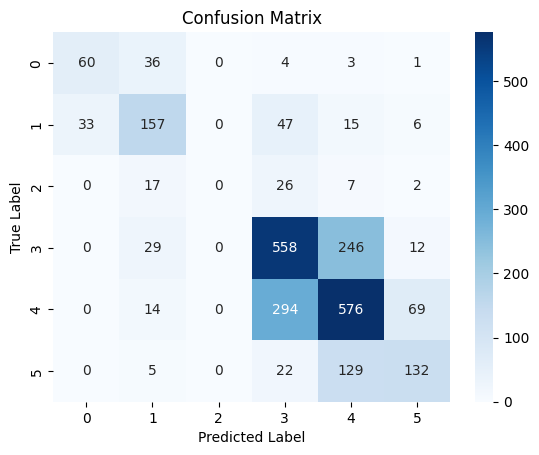

              precision    recall  f1-score   support

           0       0.65      0.58      0.61       104
           1       0.61      0.61      0.61       258
           2       0.00      0.00      0.00        52
           3       0.59      0.66      0.62       845
           4       0.59      0.60      0.60       953
           5       0.59      0.46      0.52       288

    accuracy                           0.59      2500
   macro avg       0.50      0.48      0.49      2500
weighted avg       0.58      0.59      0.59      2500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
prediction_metrics_age(cnn, encoded_test, y_test, age_classes)